In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

# Managing Portfolio : Brief Theoritical Background thru MPT

The goal of this note is to illustrate Modern Portfolio Theory (MPT): how to balance assets in a portfolio to maximize the expected return and minimize the risk.  The risk is defined to be the standard deviation of the return in MPT.

This approach may seem naive in that it oversimplifies things. (MPT is formulated by Markowitz in 1950s).  Nevertheless, it illustrates a good starting point on which we refine and base our decisions.

We start with a simple example:

## Example: two risky assets

Suppose that we have a portfolio $P$ composed of two assets, $P(X, Y)$.  We represent the composition of $P$ by

$$ P  = w X + (1-w) Y $$

For example, if $w=0.5$ then $P$ is composed of equal amount of $X$ and $Y$.

Now we denote the expected return on $P$ by $E(R_P)$. And the expected return on $X$ by $\mu_X$.
Note that
$$E(R_P) = w \mu_X + (1-w) \mu_Y $$

Now we let $\sigma^2_P$ denote the variance of the return on $P$. Note that 
$$\sigma^2_P = w^2 \sigma^2_X + (1-w)^2 \sigma^2_Y + 2w(1-w) \rho_{XY} \sigma_x \sigma_Y $$
where $\rho_{XY}$ is the correlation between the return on $X$ and $Y$.

Now we want to choose $w$ so that it maxmizes $E(R_P)$ and minimize $\sigma_P$.   
We approach this problem as an optimization problem with constraint.  That is,
we fix $E(R_P)$ and see how to find minima of $\sigma_P$ (or $\sigma^2_P$).

We make this example more concrete by assuming specific values: suppose that $\mu_X =0.14$, $\mu_Y =0.08$, $\sigma_X=0.2$, $\sigma_Y=0.15$ and $\rho_{XY} = 0$.   Then
$$ E(R_P) = 0.14 w + (1-w)0.08 = 0.08 + 0.06w$$
$$ \sigma^2_P = (0.2)^2 w^2 + (0.15)^2 (1-w)^2 $$

We note that in this simple case, we can differentiate $\sigma^2_P$ and see that it has minimum when
$$w = 0.36$$

Now we plot below $E(R_P)$ against $\sigma_P$ where parameter $w$ varies $[0,1]$
As we have seen, $\sigma_p$ is the smallest when $w=0.36$. Observe that as we increases $w$, the expected return also increases.  See red dots in the graph.  This upper half of the curve is called 'efficient frontier'.
That is, if we set the acceptable risk, the red portion is the maximum expected returns. 

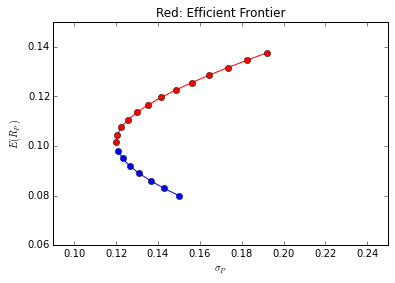

In [30]:
w  = np.arange(0.36, 1.0,0.05)

er_p =  0.08 + 0.06*w
sigma_p = (0.2)**2 * w**2 + (0.15)**2 * (1-w)**2

plt.xlim([0.09, 0.25])
plt.ylim([0.06, 0.15])
plt.ylabel('$E(R_P)$')
plt.xlabel('$\sigma_P$')
plt.title('Red: Efficient Frontier')
plt.plot(np.sqrt(sigma_p), er_p, 'o-r' )

wi = np.arange(0.0, 0.35, 0.05)

er_pi =  0.08 + 0.06*wi
sigma_pi = (0.2)**2 * wi**2 + (0.15)**2 * (1-wi)**2

plt.plot(np.sqrt(sigma_pi), er_pi, 'o-b' )


Remark: In this example we started with a simple portfolio consisting of only two assets.  This was simple enough to illuminate the idea of MPT and directly relevant to the basic pair trading model. However, we eventually need to consider more realistic porfolio examples.  To do so, we need to use matrix notation to represent component assets in their weights in a portfolio.    

We consider general MPT examples, more than two assets. 

## General Case: Optimization

### Notations

Consider a portfolio that contains $n$ assets $P(X_1, \dots , X_n)$. Each $X_i$ has expected return $R_i$
and wieght $w_i$ so that 
$$ \sum_{i=1}^n w_i =1 $$
(For example, if $P = 0.2 X_1 + 0.3 X_2 + 0.5 X_3$ then 
$$ w = \begin{bmatrix}
0.2 \\ 
0.3\\
0.5 \\
\end{bmatrix}
$$
)


We can use column vector notation for the expected returns:
$$ R = \begin{bmatrix}
R_1 \\ 
R_2\\
\cdots \\
R_n \\
\end{bmatrix}
$$

We know that the expected return on the portfolio is:
$$ E(R_P) = w_1 R_1 + \cdots + w_n R_n $$

We write this more compactly using matrix notation:
$$ E(R_P) = R^t w =
\begin{bmatrix}
R_1 & R_2 &\cdots & R_n \\
\end{bmatrix}
\begin{bmatrix}
w_1 \\ 
w_2\\
\cdots \\
w_n \\
\end{bmatrix}
$$ )

Next the variance of the return on portfolio can be written compactly
$$ \sigma^2_P = w^t C w $$
where $C$ is the covariance matrix of $R$

Now we formulate portfolio balancing problem into the following optimization problem:

#### Minimize (risk) $\sigma^2_P = w^t C w $ with constraint $R^t w = \mu$ for a fixed (expected return) $\mu$

There are many approaches to solve the above optimization problem. We start with simulation experiment;

We randomly generate the return on assets and randomly choose weights of each assets inside the portfolio.  

In [42]:
num_of_assets = 5
num_of_obs = 1000

return_vec = np.random.randn(num_of_assets, num_of_obs)

# we randomly choose weights of assets composing our portfolio
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print rand_weights(num_of_assets)

[ 0.24211888  0.02112333  0.27763449  0.17691337  0.28220994]


Next we generate portfolios using above ranmdom returns and weights: 

In [43]:
def rand_portfolio(returns):

    R = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * R.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers
    if sigma > 2:
        return rand_portfolio(returns)
    return mu, sigma

For each generated portfolio, we calculate expected retunrs and standard deviation of the returns.  Plotting 
returns against std produce shape we observed in the two assets example:

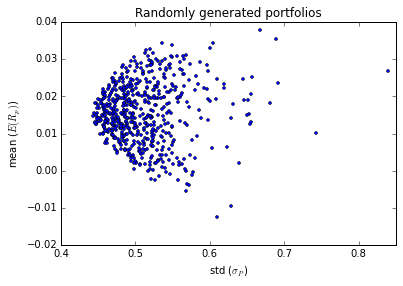

In [47]:
num_of_portfolios = 600
means, stds = np.column_stack([
    rand_portfolio(return_vec) 
    for _ in xrange(num_of_portfolios)
])

plt.plot(stds, means, 'o', markersize=3)
plt.xlabel('std ($\sigma_P$)')
plt.ylabel('mean ($E(R_p)$)')
plt.title('Randomly generated portfolios')

Since portfolios are generated randomly, most of them are not efficient.  That is, wieghts are not chosen the most efficient manner. The goal is to find $w$ so that the plot reside on the efficient frontier. 

### To Be Continued